In [256]:
import modules.ident as ident
import cv2
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as widgets
import modules.helpers as h
import glob
import os
from IPython.display import Image as IPyImage
from matplotlib.patches import Circle
from skimage import draw
from scipy.signal import find_peaks
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets.widgets import FloatSlider, IntSlider
from lmfit import Model


%matplotlib ipympl
plt.style.use(['seaborn-paper','science'])
plt.ioff()

In [4]:
data_folder = 'data'
# h.list_files(data_folder)

In [9]:
SeeAllFiles = True

In [35]:
sub_dir = './data/oct8/second'
sci_peak_data_dir = sub_dir+os.sep+"sci_peak_data"
pickle_dir = sub_dir+os.sep+"obj"

all_files = glob.glob(f"{sub_dir+os.sep}[!C_]*.JPG") ## Use regex to avoid C_ files

if SeeAllFiles == True:
    Ofiles = all_files
else:
    Ofiles = [f for f in all_files if os.path.basename(f).replace("JPG",'pkl') not in os.listdir(pickle_dir)]
    
f = lambda x: IPyImage(filename = x,width = 400, height = 200)
wi = widgets.interact(f, x = Ofiles)

interactive(children=(Dropdown(description='x', options=('./data/oct8/second/30_4.JPG', './data/oct8/second/9_…

### Imported pre-processed data

In [193]:
fname = wi.widget.kwargs['x']
f_string = os.path.basename(fname)
name = f_string.replace(".JPG","")
data_dict = h.load_obj(name, pickle_dir)
x = np.load(sci_peak_data_dir+os.sep+name+'_dist.npy')
y = np.load(sci_peak_data_dir+os.sep+name+'_data.npy')
yerr = np.sqrt(y)
yerr = np.where(yerr==0, 1, yerr) 

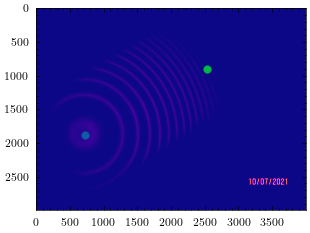

In [106]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = cv2.imread(fname).astype(np.float32)
ax.imshow(im[:,:,-1],cmap = 'plasma')
ax.scatter(*data_dict['p1'])
ax.scatter(*data_dict['p2'])
plt.show()

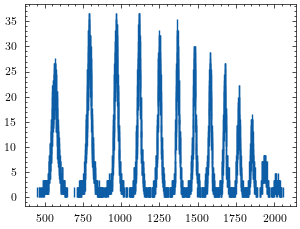

In [111]:
plt.close()
plt.figure()
plt.errorbar(x,y, yerr, ls = '')
plt.show()

#### Define relevant functions for the fit. Use three gaussians and see if they converge

In [268]:
gaussian = lambda x,m,A,s: A*np.exp(-(x-m)**2/(2*s)**2)
fit_f = lambda x, dx,m0,A0,A1,s0,s1: gaussian(x,m0-dx,A1,s1)\
    + gaussian(x,m0,A0,s0) + gaussian(x,m0+dx,A1,s1)
## Use. 0 to indicate the center peak

In [338]:
left = data_dict[0][0]; center = data_dict[0][1]; right = data_dict[0][2];

fig = plt.figure()
ax = fig.add_subplot(1,1,1)


# @interact(left = (left -20, left + 20,5), right = (right -40, right + 20,5), continuous_update=False)
# def plot(left, right):
#     x_fit = x[sel]; y_fit = y[sel];
#     try:
#         ax.lines.remove(line1)
#     except:
#         pass
#     line1 = ax.plot(x_fit,y_fit,'bo', ms = 2)
#     fig.show()

sel = np.logical_and(x>left,x<right)
x_fit = x[sel]; y_fit = y[sel]; yerr_fit = yerr[sel]


def guess(dx,m0,A0,A1,s0,s1):
    global _lines2
    line1 = ax.plot(x_fit,y_fit,'bo', ms = 2)
    _x = np.linspace(left,right,50);
    _y = fit_f(_x,dx,m0,A0,A1,s0,s1)
    try:
        ax.lines.remove(_lines2[0])
    except:
        pass
    _lines2 = ax.plot(_x,_y,'k--')
    fig.show()

## Import from previous set values    
try:
    dx = data_dict['w0']['dx'];     m0 = data_dict['w0']['m0'];     A0 = data_dict['w0']['A0'];
    A1 = data_dict['w0']['A1'];     s0 = data_dict['w0']['s0'];     s1 = data_dict['w0']['s1'];
    
except KeyError:
    dx = 20; m0 = center; A0 = 20; A1 = 10; s0 = 5; s1 = 5;
    
w = interactive(guess,
 dx = FloatSlider(value = dx, description='dx', max=100, min=0, step=3.0),
 m0 = FloatSlider(value = m0, description='m0', max=center + 20, min=center - 20, step=3.0),
 A0 = IntSlider(value = A0, description='A0', max=60, min=-20),
 A1 = IntSlider(value = A1, description='A1', max=90, min=-30),
 s0 = FloatSlider(value = s0, description='s0', max=10, min=0),
 s1 = FloatSlider(value = s1, description='s1', max=10, min=0))

w

interactive(children=(FloatSlider(value=36.0, description='dx', step=3.0), FloatSlider(value=567.3631993705619…

#### Export the guess parameters to dictionary for reusability

In [291]:
data_dict['w0'] = w.kwargs
h.save_obj(data_dict,name,pickle_dir)

In [339]:
gmodel = Model(fit_f)
print('parameter names: {}'.format(gmodel.param_names))
print('independent variables: {}'.format(gmodel.independent_vars))
params = gmodel.make_params(**w.kwargs)

parameter names: ['dx', 'm0', 'A0', 'A1', 's0', 's1']
independent variables: ['x']


In [341]:
result = gmodel.fit(y_fit,params, x = x_fit, weights = 1/yerr_fit**2)

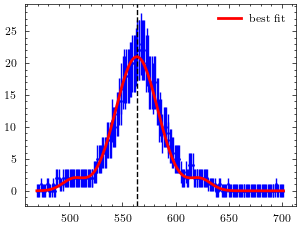

In [369]:
plt.figure()
plt.errorbar(x_fit,y_fit,yerr = yerr_fit, fmt='bo',ms = 2,zorder = 0)
# plt.plot(x_fit, result.init_fit, 'k--', label='initial fit')
plt.axvline(x = result.best_values['m0'], ls = '--', c= 'k')
plt.plot(x_fit, result.best_fit, 'r-', label='best fit',lw = 2)
plt.legend(loc='best')
plt.show()